# Прикладные задачи анализа данных

## Домашнее задание 4

В этой работе мы будем решать задачу рекомендаций музыки. Для этого мы реализуем метод коллаборативной фильтрации и модель со скрытыми переменными, сравним их между собой и попытаемся сделать выводы. Во всех заданиях разрешается переписывать код по своему усмотрению, предложенные шаблоны несут лишь рекомендательный характер. За дополнительные эксперименты с методами и их анализ можно получить бонусные баллы.

In [ ]:
from sklearn.preprocessing import LabelEncoder

import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
from typing import Callable, List

import matplotlib.pyplot as plt
import seaborn as sns
import scipy.sparse as scs

In [ ]:
ratings = pd.read_csv('/content/music_dataset.csv')
ratings.head()

,userId,trackId
0,0,14
1,0,95
2,0,219
3,0,220
4,0,404


In [ ]:
tracks_info = pd.read_csv('/content/tracks_info.csv')
tracks_info.head()

,id,name,artists
0,0,What There Is,['a-ha']
1,1,I'll Play The Blues For You,['Albert King']
2,2,Breaking Up Somebody's Home,['Albert King']
3,3,Imma Be,['Black Eyed Peas']
4,4,Boom Boom Pow,['Black Eyed Peas']


Для оценки качества рекомендаций мы будем использовать метрику $MAP@k$.

$$
MAP@k = \frac{1}{N} \sum_{u = 1}^N AP_u@k
$$
$$
AP_u@k = \frac{1}{\min(k, n_u)} \sum_{i=1}^k r_u(i) p_u@i
$$
$$p_u@k = \dfrac{1}{k}\sum_{j=1}^k r_u(j)$$


*   $N$ - количество пользователей.
*   $n_u$ - число релевантных треков пользователя $u$ на тестовом промежутке.
*   $r_u(i)$ - бинарная величина: относится ли трек на позиции $i$ к релевантным.

**Задание 1 (0.5 балла).** Реализуйте метрику $MAP@k$.

вот тут вдохновлялась https://www.kaggle.com/code/nandeshwar/mean-average-precision-map-k-metric-explained-code

In [ ]:
def apk(relevant: List[List[int]], predicted: List[List[int]], k: int = 20):
    if not relevant:
        return 0.0

    if len(predicted)>k:
        predicted = predicted[:k]

    score = 0.0
    num_hits = 0.0

    for i,p in enumerate(predicted):
        # first condition checks whether it is valid prediction
        # second condition checks if prediction is not repeated
        if p in relevant and p not in predicted[:i]:
            num_hits += 1.0
            score += num_hits / (i+1.0)

    return score / min(len(relevant), k)

In [ ]:
def mapk(relevant: List[List[int]], predicted: List[List[int]], k: int = 20):
    return np.mean([apk(a,p,k) for a,p in zip(relevant, predicted)])


In [ ]:
relevant = [
    [1, 7, 6, 2, 8],
    [1, 5, 4, 8],
    [8, 2, 5]
]

pred = [
    [8, 1, 5, 0, 7, 2, 9, 4],
    [0, 1, 8, 5, 3, 4, 7, 9],
    [9, 2, 0, 6, 8, 5, 3, 7]
]

assert round(mapk(relevant, pred, k=5), 4) == 0.4331

Разделим данные на тренировочные и тестовые так, чтобы в теcтовый датасет попали 50 последних треков каждого пользователя.

In [ ]:
def train_test_split(ratings):
    train_ratings, test_ratings = [], []
    num_test_samples = 50

    # getting train samples
    for userId, user_data in tqdm(ratings.groupby('userId')):
        train_ratings += [user_data[:-num_test_samples]]

    train_ratings = pd.concat(train_ratings).reset_index(drop=True)
    all_train_items = train_ratings['trackId'].unique()

    # getting train samples
    # we drop all tracks that are not presented it the training samples,
    # because we won't be able to learn representations for them
    for userId, user_data in tqdm(ratings.groupby('userId')):
        test_items = user_data[-num_test_samples:]
        test_items = test_items[np.isin(test_items['trackId'], all_train_items)]
        test_ratings += [test_items]

    test_ratings = pd.concat(test_ratings).reset_index(drop=True)

    return train_ratings, test_ratings

In [ ]:
train_ratings, test_ratings = train_test_split(ratings)

  0%|          | 0/241 [00:00<?, ?it/s]

  0%|          | 0/241 [00:00<?, ?it/s]

Почистим табличку с информацией о треках и закодируем id треков так, чтобы они соответствовали их порядковому номеру.

In [ ]:
redundant_rows = np.where(~np.isin(tracks_info['id'], train_ratings['trackId'].unique()))[0]
tracks_info.drop(redundant_rows, inplace=True)
tracks_info = tracks_info.reset_index(drop=True)

In [ ]:
def ids_encoder(ratings):
    users = sorted(ratings['userId'].unique())
    items = sorted(ratings['trackId'].unique())

    # create users and items encoders
    uencoder = LabelEncoder()
    iencoder = LabelEncoder()

    # fit users and items ids to the corresponding encoder
    uencoder.fit(users)
    iencoder.fit(items)

    return uencoder, iencoder

In [ ]:
uencoder, iencoder = ids_encoder(train_ratings)
train_ratings['trackId'] = iencoder.transform(train_ratings['trackId'].tolist())
test_ratings['trackId'] = iencoder.transform(test_ratings['trackId'].tolist())
tracks_info['id'] = iencoder.transform(tracks_info['id'].tolist())

In [ ]:
train_ratings.head()

,userId,trackId
0,0,14
1,0,95
2,0,219
3,0,220
4,0,404


In [ ]:
test_ratings.head()

,userId,trackId
0,0,57582
1,0,57802
2,0,57957
3,0,58174
4,0,59168


Соберем все релевантные треки для каждого пользователя в список.

In [ ]:
test_relevant = []
test_users = []
for user_id, user_data in test_ratings.groupby('userId'):
    test_relevant += [user_data['trackId'].tolist()]
    test_users.append(user_id)

**Задание 2 (0.5 балла).** Реализуйте метод `get_test_recommendations` в классе `BaseModel`. Он принимает на вход параметр `k` и возвращает массив из `k` наиболее подходящих треков для каждого пользователя. Не забывайте удалять уже прослушанные треки из рекомендуемых.

приветики из будущего! я сразу тут оформлю возможность использовать sparce. Так как разреженность у нас по строчкам ибо бывают треки которые слушали все, мы будем использовать `compressed sparse row format` (то есть `scipy.csr_matrix`)

In [ ]:
from scipy.sparse import (
    csr_matrix,
    hstack,
    vstack
)

In [ ]:
class BaseModel:
    def __init__(self, ratings: pd.DataFrame, use_sparse=False):
        self.ratings = ratings
        self.n_users = len(np.unique(self.ratings['userId']))
        self.n_items = len(np.unique(self.ratings['trackId']))
        self.use_sparse = use_sparse

        self.R = np.zeros((self.n_users, self.n_items))
        self.R[self.ratings['userId'], self.ratings['trackId']] = 1.
        if self.use_sparse:
          self.R = csr_matrix(self.R)

    def remove_train_items(self, preds: List[List[int]], k: int):
        """
        param preds: [n_users, n_items] - recommended items for each user
        param k: int
        return: np.array [n_users, k] - recommended items without training examples
        """
        new_preds = np.zeros((len(preds), k), dtype=int)
        for user_id, user_data in self.ratings.groupby('userId'):
            user_preds = np.array(preds[user_id])
            new_preds[user_id] = user_preds[~np.in1d(user_preds, user_data['trackId'])][:k]

        return new_preds#.tolist()

    def get_test_recommendations(self, k: int):
        test_preds = [None] * self.n_users

        for uid, _ in tqdm(self.ratings.groupby('userId')):
          recommended = self.recommend(uid)
          test_preds[uid] = recommended
        test_preds_remove_train = self.remove_train_items(test_preds, k)

        return test_preds_remove_train

## Часть 1. Коллаборативная фильтрация (User2User)

Идея: чтобы выбрать треки, которые понравятся пользователю, можно набрать несколько похожих на него пользователей (соседей) и посмотреть, какие треки они слушают. После этого остается агрегировать треки этих пользователей и выбрать самые популярные. Соответственно, задача состоит из двух частей: выбора функции похожести двух пользователей и способа агрегации.

В качестве функции похожести мы будем использовать две метрики:

1. Корреляция Пирсона $$s(u, v) = \frac{\sum_{i \in I_u \cap I_v} r_{ui}r_{vi}}{\sqrt{\sum_{i \in I_u} r_{ui} ^2}\sqrt{\sum_{i \in I_v} r_{vi}^2}} $$

2. Мера Жаккара

$$ s(u, v) = \frac{|I_u \cap I_v|}{|I_u \cup I_v|} $$


Корреляция Пирсона немного видоизменена, чтобы подходить под нашу задачу.


Во всех формулах
* $I_u$ - множество треков, прослушанных пользователем $u$.
* $r_{ui}$ - прослушал ли пользователь $u$ трек $i$ (0 или 1).

Множество соседей определим как $$N(u) = \{ v \in U \setminus \{u\} \mid s(u, v) > \alpha\},$$ где $\alpha \, - $ гиперпараметр.



Для агрегации мы будем пользоваться следующей формулой.
$$
\hat{r}_{ui} = \frac{\sum_{v \in N(u)} s(u, v) r_{vi}}{\sum_{v \in N(u)} |s(u, v)|}
$$

**Задание 3.1 (0.5 балла).** Реализуйте функцию подсчета корреляции Пирсона.

**Задание 3.2 (0.5 балла).** Реализуйте функцию подсчета меры Жаккара.

Функции принимают матрицу оценок и вектор оценок пользователя $u$ и возвращают вектор со значениями похожести пользователя $u$ на всех пользователей. Старайтесь писать оптимизированный код, за неэффективную реализацию оценка может быть снижена.

In [ ]:
A = csr_matrix(np.arange(15).reshape(5, 3))
A.sum(axis=1)

matrix([[ 3],
        [12],
        [21],
        [30],
        [39]])

In [ ]:
def pearson(ratings: np.array, user_vector: np.array) -> np.array:
    R_u = np.tile(user_vector, (ratings.shape[0], 1))
    num = (R_u * ratings.A).sum(axis=1)
    den = np.sqrt(R_u.sum(axis=1) * ratings.sum(axis=1))

    result = num / den
    return result

def jaccard(ratings: np.array, user_vector: np.array) -> np.array:
    R_u = np.tile(user_vector, (ratings.shape[0], 1))
    cap = R_u * ratings.A

    cup = R_u + ratings - cap
    return cap.sum(axis=1) / cup.sum(axis=1)

**Задание 4 (1 балл).** Реализуйте методы `similarity` и `recommend` класса `User2User`. `recommend` возвращает индексы треков, отсортированные в порядке убывания предсказанных оценок.


In [ ]:
class User2User(BaseModel):
    def __init__(self, ratings, similarity_func, use_sparse=False):
        super().__init__(ratings, use_sparse)

        assert similarity_func in [pearson, jaccard]

        self.similarity_func = similarity_func
        self.alpha = 0.02

    def get__similarities_N(self, user_vector: np.array):
        """
        user_vector: [n_items]
        """
        similarities = self.similarity_func(self.R, user_vector)
        neighbours_index = (
            (similarities > self.alpha) & (similarities != 1) # ensure u is excluded from N(u)
        )
        similarities = similarities[neighbours_index]
        return similarities, self.R[neighbours_index]

    def get_r_u_hat(self, uid: int):
        user_vector = self.R[uid]
        if self.use_sparse:
          user_vector = csr_matrix(user_vector)
        similarities, N = self.get__similarities_N(user_vector)
        den = np.abs(similarities).sum()
        den = np.tile(den, (self.n_items, ))

        coef = np.tile(similarities, (self.n_items, 1)).T
        num = (coef * N).sum(axis=0)
        return num / den


    def recommend(self, uid: int):
        user_vector = self.R[uid, :]
        if self.use_sparse:
          user_vector = csr_matrix(user_vector)
        r_u_hat = self.get_r_u_hat(uid)
        return r_u_hat.argsort()[::-1].tolist()


In [ ]:
Recommender = User2User(ratings, pearson)
similarities, N = Recommender.get__similarities_N(Recommender.R[3, :])

**Задание 5 (1 балл).** Постройте графики зависимости значений $MAP@k$ от разных $k$ для обоих функций похожести, сравните их между собой, а также с предсказаниями случайного алгоритма и сделайте выводы.

In [ ]:
class RecommendTop(BaseModel):
    def __init__(self, ratings):
        super().__init__(ratings)
        self.ratings = ratings
        self.n_users = len(np.unique(self.ratings['userId']))
        self.n_items = len(np.unique(self.ratings['trackId']))

        self.R = np.zeros((self.n_users, self.n_items))
        self.R[self.ratings['userId'], self.ratings['trackId']] = 1.

    def recommend(self, uid):
      top = self.R.sum(axis=1)
      return top.argsort()[::-1].tolist()

class RecommendRandom(BaseModel):
    def __init__(self, ratings):
        super().__init__(ratings)
        self.ratings = ratings
        self.n_users = len(np.unique(self.ratings['userId']))
        self.n_items = len(np.unique(self.ratings['trackId']))

        self.R = np.zeros((self.n_users, self.n_items))
        self.R[self.ratings['userId'], self.ratings['trackId']] = 1.

    def recommend(self, uid):
      random = np.random.permutation(self.n_items)
      return random.tolist()

In [ ]:
from tqdm import tqdm

k_list = [1, 2, 3, 5,
          10, 15, 25, 50,
          100, 500,
          1000, 5000,
          10000, 20000, 40000, 50000, 72382]
map_list_pearson = []
map_list_jaccard = []
map_list_top = []
map_list_random = []

relevant = [x for x in test_ratings.groupby('userId')['trackId'].apply(list)]

for k in tqdm(k_list):
  #top
  top = RecommendTop(ratings)
  predicted = []
  for uid in range(top.n_users):
    prediction = top.recommend(uid)
    predicted.append(prediction)

  mapk_score = mapk(relevant, predicted, k)

  map_list_top.append(mapk_score)

  #random
  random = RecommendRandom(ratings)
  predicted = []
  for uid in range(random.n_users):
    prediction = random.recommend(uid)
    predicted.append(prediction)

  mapk_score = mapk(relevant, predicted, k)

  map_list_random.append(mapk_score)

  for similarity_func in tqdm([pearson, jaccard]):
    pearson_flag = (similarity_func == pearson)
    # u2u
    u2u = User2User(ratings, similarity_func)
    predicted = []
    for uid in range(u2u.n_users):
      prediction = u2u.recommend(uid)
      predicted.append(prediction)

    mapk_score = mapk(relevant, predicted, k)

    if pearson_flag:
      map_list_pearson.append(mapk_score)
    else:
      map_list_jaccard.append(mapk_score)

  0%|          | 0/2 [00:00<?, ?it/s]<ipython-input-21-51b7ad8fbd09>:31: RuntimeWarning: invalid value encountered in true_divide
  return num / den

100%|██████████| 17/17 [39:17<00:00, 138.70s/it]


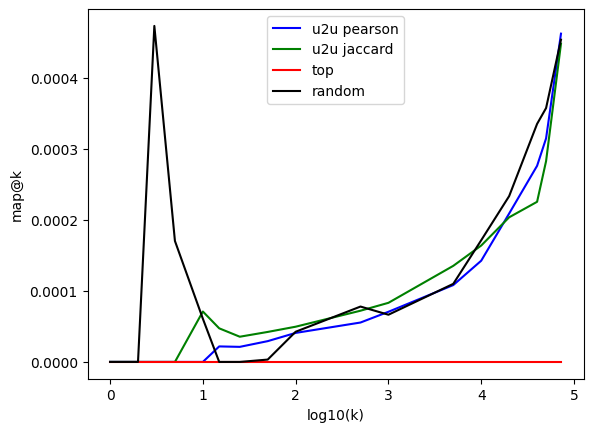

In [ ]:
plt.plot(np.log10(k_list), map_list_pearson, 'b', label='u2u pearson')
plt.plot(np.log10(k_list), map_list_jaccard, 'g', label='u2u jaccard')
plt.plot(np.log10(k_list), map_list_top, 'r', label='top')
plt.plot(np.log10(k_list), map_list_random, 'k', label='random')
plt.xlabel('log10(k)')
plt.ylabel('map@k')
plt.legend()

**Задание 6 (1.5 балла).** Как вы могли заметить, матрица оценок получается очень разреженной, но мы работаем с ней как с обычной, это не дело. Перепишите код так, чтобы все методы могли работать с разреженными матрицами и сравните скорость работы такого подхода с оригинальным.

ниже в тетрадке посчитана ячейка `model.get_test_recommendations(15)` со скоростью `1min 11s ± 1.66 s`. Будем считать это за baseline


прогоним ту же model , но с `sparse_flag=True`


In [ ]:
model = User2User(ratings, similarity_func=pearson, use_sparse=True)

In [ ]:
%%timeit

preds = model.get_test_recommendations(15)

  0%|          | 0/241 [00:00<?, ?it/s]

к сожалению все упало (your session crashed after using all avaliable ram)

Мы можем посмотреть глазами, насколько хорошо модель рекомендует треки. Для этого сравним уже прослушанные треки с рекомендованными и релевантными для случайного пользователя. Хорошо ли у вас получилось?

In [ ]:
model = User2User(ratings, similarity_func=pearson)

In [ ]:
user_id = np.random.randint(0, model.n_users)
user_id

206

In [ ]:
listened_tracks = train_ratings[train_ratings.userId == user_id].trackId[:15]

print('Already listened tracks:')

tracks_info.loc[listened_tracks][['name', 'artists']]

Already listened tracks:


,name,artists
97,Heads Will Roll,['Yeah Yeah Yeahs']
164,My Favourite Game,['The Cardigans']
177,Paper Planes,['M.I.A.']
344,Somebody Told Me,['The Killers']
556,All These Things That I've Done,['The Killers']
776,When You Were Young,['The Killers']
780,Heart-Shaped Box,['Nirvana']
781,Pennyroyal Tea,['Nirvana']
784,Dumb,['Nirvana']
785,Rape Me,['Nirvana']


In [ ]:
%%timeit

preds = model.get_test_recommendations(15)

 34%|███▎      | 81/241 [00:25<00:47,  3.37it/s]<ipython-input-21-51b7ad8fbd09>:31: RuntimeWarning: invalid value encountered in true_divide
  return num / den
 34%|███▎      | 81/241 [00:22<00:55,  2.86it/s]<ipython-input-21-51b7ad8fbd09>:31: RuntimeWarning: invalid value encountered in true_divide
  return num / den
 34%|███▎      | 81/241 [00:22<00:45,  3.54it/s]<ipython-input-21-51b7ad8fbd09>:31: RuntimeWarning: invalid value encountered in true_divide
  return num / den
 34%|███▎      | 81/241 [00:23<00:39,  4.03it/s]<ipython-input-21-51b7ad8fbd09>:31: RuntimeWarning: invalid value encountered in true_divide
  return num / den
 34%|███▎      | 81/241 [00:21<00:52,  3.02it/s]<ipython-input-21-51b7ad8fbd09>:31: RuntimeWarning: invalid value encountered in true_divide
  return num / den
 34%|███▎      | 81/241 [00:22<00:39,  4.04it/s]<ipython-input-21-51b7ad8fbd09>:31: RuntimeWarning: invalid value encountered in true_divide
  return num / den
 34%|███▎      | 81/241 [00:24<00:54,  2

1min 11s ± 1.66 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [ ]:
print('Predicted tracks:')

tracks_info.loc[preds[user_id]][['name', 'artists']]

Predicted tracks:


,name,artists
14789,Retreat! Retreat!,['65daysofstatic']
2814,Numb,['Linkin Park']
11502,"Baby, Its Cold Outside",['Rosemary Clooney']
7780,ИСКАЛА,['Земфира']
23516,I Really Like You,"['Carly Rae Jepsen', 'Liam Keegan']"
11964,Межличностный конфликт,['Монгол Шуудан']
18496,Carrying You,['Yoshihiro Koseki']
33677,Caribbean Rave,['W&W']
1019,It's My Life,['Bon Jovi']
57031,I Love You,['Frank Sinatra']


In [ ]:
test_tracks = test_ratings[test_ratings.userId == user_id].trackId[:15]

print('Test-time tracks:')

tracks_info.loc[test_tracks][['name', 'artists']]

Test-time tracks:


,name,artists
53278,My Beautiful Madness,['Pyrokinesis']
53279,"В городе, где гаснут фонари",['Pyrokinesis']
53280,Чёрное солнышко,['Pyrokinesis']
53281,Сигаретка без кнопки,['Pyrokinesis']
53283,"Почему, да потому что",['Pyrokinesis']
53284,Пальчики паноптикум,['Pyrokinesis']
53285,Моя милая пустота,['Pyrokinesis']
53286,"Гепатит, СПИД, сифилис",['Pyrokinesis']
53287,Сколопендра,['Pyrokinesis']
53288,Виа Долороса,['Pyrokinesis']


### Часть 2. Модель со скрытыми переменными

В этой части мы пощупаем метод рекомендаций со скрытыми переменными.
Идея: будем предсказывать оценки по формуле
$$
\hat{r}_{ui} = \langle p_u, q_u \rangle,
$$
$p_u \in \mathbb{R}^d$ и $q_i \in \mathbb{R}^d$ - латентные векторы пользователя $u$ и объекта $i$ соответственно.

Оптимизировать мы будем MSE между истинной оценкой пользователя и предсказанной с регуляризацией
$$
L = \sum_{(u, i) \in R} (\hat{r}_{ui} - r_{ui})^2 + \lambda \left(\sum_{u \in U} \|p_u\|^2 + \sum_{i \in I} \|q_i\|^2\right)
$$

**Задание 7 (1.5 балла).** На лекции рассматривались два подхода к оптимизации параметров. Можно это делать обычным стохастческим градинтным спуском, а можно по очереди обновлять матрицы $P, Q$, и тогда получится метод Alternating Least Squares (ALS). Выведите формулы обновления параметров для обоих методов.

снова вдохновение [ml-cource-hse lecture23-recommender](https://github.com/esokolov/ml-course-hse/blob/master/2020-spring/lecture-notes/lecture23-recommender.pdf) (с дополнением регуляризации)

LFM:

перебираем каждую пару $(u, i)\in R$

$$p_{uk}=p_{uk}+\eta q_{ik}(r_{ui}-\langle p_u, q_i\rangle)-\eta\lambda p_{uk} \;\forall k\in\{1, \ldots, \text{n_items}\}$$

$$q_{ik}=q_{ik}+\eta p_{uk}(r_{ui}-\langle p_u, q_i\rangle)-\eta\lambda q_{ik}\;\forall k\in\{1, \ldots, \text{n_items}\}$$


\\
ALS:

$$q_i = \left(\sum_{i:\exists r_{ui}}q_i q_i^t\right)^{-1}\sum_{i:\exists r_{ui}}r_{ui} q_i=:A^{-1}a$$

$$p_u = \left(\sum_{i:\exists r_{ui}}p_u p_u^t\right)^{-1}\sum_{i:\exists r_{ui}}r_{ui} p_u=:B^{-1}b,$$

где $p_u$ и $q_i$ -- эмбеддинги (столбцы $P$ и $Q$ соотв.)
в нашем случае $\{i:\exists r_{ui}\}$ -- это все айтемы т.к. рейтинг бинарный


**Задание 8 (2 балла).** Реализуйте методы оптимизации параметров для обоих алгоритмов.

In [ ]:
class HiddenVars(BaseModel):
    def __init__(self, ratings, dim=128, mode='sgd'):
        super().__init__(ratings)
        self.dim = dim

        assert mode in ['sgd', 'als']
        self.mode = mode

        self.P = np.random.normal(scale=1.0 / self.dim, size=(self.n_users, self.dim))
        self.Q = np.random.normal(scale=1.0 / self.dim, size=(self.n_items, self.dim))

        self.lr = 0.0003
        self.lamb = 0.01

    def fit(self, num_iters=5):
        for epoch_num in tqdm(range(num_iters)):

            if self.mode == 'sgd':
                for uid in range(self.n_users):
                    for i in range(self.n_items):
                      if self.R[uid, i] == 1: # wo this too long
                        err = self.R[uid, i] - self.predict(uid, i)
                        self.P[uid] += self.lr * (err * self.Q[i] - self.lamb * self.P[uid])
                        self.Q[i] += self.lr * (err * self.P[uid] - self.lamb * self.Q[i])

            elif self.mode == 'als':
              for uid in range(self.n_users):
                A = np.zeros((self.dim, self.dim))
                r_u = self.R[uid]
                for i in range(self.n_items):
                  if self.R[uid, i] == 1:
                    q = self.Q[i]
                    A_i = q.reshape((-1, 1)) @  q.reshape((1, -1))
                    A += A_i

                if np.linalg.matrix_rank(A) == self.dim:
                  a = (self.Q * np.tile(
                      r_u, (self.dim, 1)
                  ).T).sum(axis=0)
                  self.P[uid] = np.linalg.inv(A) @ a

              # for i in range(-num_iters, self.n_items, num_iters):
              for i in range(self.n_items):
                if i >= 0:
                  r_i = self.R[:, i]
                  B = np.zeros((self.dim, self.dim))
                  for u in range(self.n_users):
                    if self.R[uid, i] == 1:
                      p = self.P[u]
                      B_i = p.reshape((-1, 1)) @  p.reshape((1, -1))
                      B += B_i
                  if np.linalg.matrix_rank(B) == self.dim:
                    b = (self.P * np.tile(
                        r_i, (self.dim, 1)
                    ).T).sum(axis=0)
                    self.Q[i] = np.linalg.inv(B) @ b

    def predict(self, u, i):
        return np.dot(self.P[u], self.Q[i])

    def recommend(self, uid):
        pred_rating = self.P[uid] @ self.Q.T
        return np.argsort(pred_rating)[::-1]

теперь проверим

In [ ]:
sgd = HiddenVars(ratings, mode='sgd')
sgd.fit(5)
sgd_preds = sgd.get_test_recommendations(8)

100%|██████████| 241/241 [00:05<00:00, 47.39it/s]


In [ ]:
print('sgd Predicted tracks for a random user:')

tracks_info.loc[sgd_preds[42]][['name', 'artists']]

sgd Predicted tracks for a random user:


,name,artists
12332,"Girl, Forever",['Satin Jackets']
16260,Requiem for a Tower,['London Music Works']
9864,Mr. Bass Man,['Johnny Cymbal']
31607,Тишина,['BY Effect']
24486,The Vampire Masquerade,['Peter Gundry']
22685,Chandelier,['The Wind and The Wave']
53510,У природы нет плохой погоды,['Алиса Фрейндлих']
14231,Юлия,['Ленинград']


In [ ]:
als = HiddenVars(ratings, mode='als', dim=258)
als.fit(10)
als_preds = als.get_test_recommendations(8)

100%|██████████| 241/241 [00:07<00:00, 31.40it/s]


In [ ]:
print('als Predicted tracks for a random user:')

tracks_info.loc[als_preds[42]][['name', 'artists']]

als Predicted tracks for a random user:


,name,artists
62292,Help Me,['DR4MX']
17595,Молитва и пост,['Аквариум']
52921,Seashore Silence 2019,['Green Sun']
52108,Lemon,['Mindaryn']
45136,Wild Wild Son,"['Armin van Buuren', 'Sam Martin']"
66391,Abyss,['KSLV Noh']
57746,Overcome,['NBSPLV']
12159,More Than Ever,['Rebelution']


In [ ]:
k_list = [1, 2, 3, 5,
          10, 15, 25, 50,
          100, 500,
          1000, 5000,
          10000, 20000, 40000, 50000, 72382]
map_list_sgd = []
map_list_als = []

relevant = [x for x in test_ratings.groupby('userId')['trackId'].apply(list)]

for k in tqdm(k_list):
  predicted = []
  for uid in range(sgd.n_users):
    prediction = sgd.recommend(uid)
    predicted.append(prediction)

  mapk_score = mapk(relevant, predicted, k)
  map_list_sgd.append(mapk_score)

for k in tqdm(k_list):
  predicted = []
  for uid in range(als.n_users):
    prediction = als.recommend(uid)
    predicted.append(prediction)

  mapk_score = mapk(relevant, predicted, k)
  map_list_als.append(mapk_score)

100%|██████████| 17/17 [05:22<00:00, 18.99s/it]


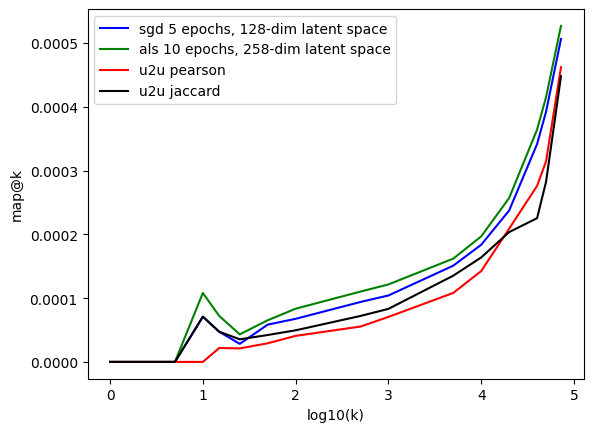

In [ ]:
plt.plot(np.log10(k_list), map_list_sgd, 'b', label='sgd 5 epochs, 128-dim latent space')
plt.plot(np.log10(k_list), map_list_als, 'g', label='als 10 epochs, 258-dim latent space')
plt.plot(np.log10(k_list), map_list_pearson, 'r', label='u2u pearson')
plt.plot(np.log10(k_list), map_list_jaccard, 'k', label='u2u jaccard')
plt.xlabel('log10(k)')
plt.ylabel('map@k')
plt.legend()

**Задание 9 (1 балл).** Для обоих алгоритмов подберите оптимальные значения размерности скрытого пространства $d$ и размера предсказания $k$. Как изменяется качество предсказаний с числом итераций обучения? Постройте соответствующие графики, сравните со случайным подхом и User2User, сделайте выводы. Какой алгоритм вам кажется более подходящим для данной задачи и почему?

P.S. Хотя бы один из методов обучения должен приводить к лучшим результатам в сравнении с User2User подходом.

P.P.S. Методу LFM свойственно переобучаться, поэтому при подборе параметров полезно смотреть на значения ошибки и оптимизируемой метрики на тренировочном датасете. Вы также можете менять начальную инициализацию и прочие параметры, за исключением архитектуры, на ваш вкус.

* als обучается слишком долго, чтобы делать гридсёрч
* я пробовала 128-dim 5 эпох als и он уже показывал себя чуточку лучше sgd с теми же параметрами
* я пробовала 258-dim 5 эпох, но прыгать по uid через 5 (первая эпоха -- юзеры 0, 5, 10; вторая -- 1, 6, 11; и т.д.). Однако новизна этого подхода меня отталкивала. Качество было такое же
* в конце концов 2.5 часа я обучала 10 эпох 258-dim, и он оказался лучше всех!

Если у вас получилось достаточно хорошее качество, то при оптимизации параметров марицы $Q$ похожим трекам стали соответствовать похожие векторы. Поэтому мы можем для любого трека найти наиболее близкие к нему в латентном пространстве и проверить степерь обученности модели вручную.

In [ ]:
example_trackId = tracks_info[tracks_info.name == 'Planet Caravan'].iloc[0].id

preds = als.Q @ als.Q[example_trackId]
preds = preds / np.sqrt((als.Q**2).sum(axis=1) + 1e-8)

track_idxs = preds.argsort()[::-1][:10]

In [ ]:
similar_tracks = tracks_info.loc[track_idxs][['name', 'artists']]
similar_tracks['similarity'] = preds[track_idxs] / np.linalg.norm(als.Q[example_trackId])
similar_tracks

,name,artists,similarity
93,Planet Caravan,['Black Sabbath'],0.999999
62216,Hadal Ahbek,['Issam Alnajjar'],0.233603
28896,Тень 5. Ричард Гордон,['Король и Шут'],0.233368
45090,LET ME FIND OUT,"['Jordan Hollywood', 'Lil Baby']",0.227556
24276,Корвет уходит в небеса,['Агата Кристи'],0.227377
6217,Everytime,['Britney Spears'],0.226752
28232,Чио-Чио-сан,['Кар-Мэн'],0.223400
13973,The Village,"['Lee Ritenour', 'George Duke', 'Stanley Clark...",0.222945
42664,Невесомы,['Mainstream One'],0.222573
57954,Don't You Forget,"['Parov Stelar', 'Anduze', 'Lilja Bloom']",0.221553


нуууу... с натяжкой...